Established Twitter connection.
Read screen names: ['DrJillStein', 'GovGaryJohnson', 'HillaryClinton', 'Aaronwc', 'realDonaldTrump']
found 5 users with screen_names ['Aaronwc', 'DrJillStein', 'GovGaryJohnson', 'HillaryClinton', 'realDonaldTrump']
Friends per candidate:
Aaronwc 73
DrJillStein 1648
GovGaryJohnson 3481
HillaryClinton 762
realDonaldTrump 45
Most common friends:
[(216776631, 3), (18766459, 3), (19608297, 3), (822215673812119553, 3), (14222536, 2)]
Friend Overlap:
[('DrJillStein', 'GovGaryJohnson', 238), ('GovGaryJohnson', 'HillaryClinton', 14), ('GovGaryJohnson', 'realDonaldTrump', 13), ('Aaronwc', 'GovGaryJohnson', 3), ('DrJillStein', 'HillaryClinton', 3), ('Aaronwc', 'HillaryClinton', 2), ('Aaronwc', 'DrJillStein', 1), ('HillaryClinton', 'realDonaldTrump', 1), ('Aaronwc', 'realDonaldTrump', 0), ('DrJillStein', 'realDonaldTrump', 0)]
User followed by Hillary and Donald: WhiteHouse
graph has 272 nodes and 538 edges
network drawn to network.png


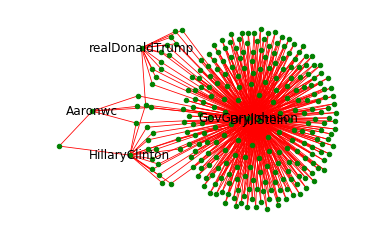

In [71]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import sys
import time
from TwitterAPI import TwitterAPI
import warnings

consumer_key = '8VEfsBxDFtmN0xHYM0saAf7Dq'
consumer_secret = 'Imtc63LZhSs0UvkMBqxUfLnHJEInDjhevY8ojFPo0y9klgnGFX'
access_token = '148849891-90859yOIGG33fmEdhhlHtzMK2EPOz4EoacXEj53s'
access_token_secret = 'SnrSM5FQnpLpgtJh0q7CfZxvZ9RprC0afXGq74fEvekXU'

def get_twitter():
    """Returns: An instance of TwitterAPI """
    return TwitterAPI(consumer_key, consumer_secret, access_token, access_token_secret)
get_twitter()

def read_screen_names(filename):
    """Read a text file containing Twitter screen_names, one per line.
    Params:
        filename....Name of the file to read.
    Returns:
        A list of strings, one per screen_name, in the order they are listed
        in the file."""
    screen_names = []
    File = open(filename,"r") 
    screen_names = File.read().splitlines()
    File.close()
    return screen_names  


def robust_request(twitter,resource,params,max_tries=5):
    """ If a Twitter request fails, sleep for 15 minutes.
    Do this at most max_tries times before quitting.
    Args:
      twitter .... A TwitterAPI object.
      resource ... A resource string to request; e.g., "friends/ids"
      params ..... A parameter dict for the request, e.g., to specify
                   parameters like screen_name or count.
      max_tries .. The maximum number of tries to attempt.
    Returns:
      A TwitterResponse object, or None if failed.
    """
    for i in range(max_tries):
        request = twitter.request(resource,params)
        if request.status_code == 200:
            return request
        else:
            print('Got error %s \nsleeping for 15 minutes.' % request.text)
            sys.stderr.flush()
            time.sleep(61 * 15)
            
            
def get_users(twitter,screen_names):
    """Retrieve the Twitter user objects for each screen_name.
    Params:
        twitter........The TwitterAPI object.
        screen_names...A list of strings, one per screen_name
    Returns:
        A list of dicts, one per user, containing all the user information
        (e.g., screen_name, id, location, etc)"""
    request = robust_request(twitter,'users/lookup', {'screen_name':screen_names},max_tries=5) 
    user_object = [r for r in request]
    return user_object


def get_friends(twitter, screen_name):
    """ Return a list of Twitter IDs for users that this person follows, up to 5000.
    See https://dev.twitter.com/rest/reference/get/friends/ids
    Note, because of rate limits, it's best to test this method for one candidate before trying
    on all candidates.
    Args:
        twitter.......The TwitterAPI object
        screen_name... a string of a Twitter screen name
    Returns
        A list of ints, one per friend ID, sorted in ascending order."""
    request = robust_request(twitter,'friends/ids', {'screen_name':screen_name,'count':5000,'cursor':-1},max_tries=5)
    person_follows = [r for r in request]
    person_follows.sort()
    return person_follows


def add_all_friends(twitter, users):
    """ Get the list of accounts each user follows.
    I.e., call the get_friends method for all 4 candidates.
    Store the result in each user's dict using a new key called 'friends'.
    Args:
        twitter...The TwitterAPI object.
        users.....The list of user dicts.
    Returns:
        Nothing"""
    for i in range(len(users)):
        followers = get_friends(twitter,users[i]['screen_name'])
        users[i]['friends']=followers


def print_num_friends(users):
    """Print the number of friends per candidate, sorted by candidate name.
    See Log.txt for an example.
    Args:
        users....The list of user dicts.
    Returns:
        Nothing
    """
    for i in range(len(users)):
        counts = Counter()
        counts.update(users[i]['friends'])
        print ('%s %d' %(users[i]['screen_name'],len(counts)))

def count_friends(users):
    """ Count how often each friend is followed.
    Args:
        users: a list of user dicts
    Returns:
        a Counter object mapping each friend to the number of candidates who follow them.
        Counter documentation: https://docs.python.org/dev/library/collections.html#collections.Counter"""
    count = Counter()
    for i in range(len(users)):
        count.update(users[i]['friends'])
    return count


def friend_overlap(users):
    """
    Compute the number of shared accounts followed by each pair of users.
    Args:
        users...The list of user dicts.
    Return: A list of tuples containing (user1, user2, N), where N is the
        number of accounts that both user1 and user2 follow.  This list should
        be sorted in descending order of N. Ties are broken first by user1's
        screen_name, then by user2's screen_name (sorted in ascending
        alphabetical order). See Python's builtin sorted method."""
    friends_overlap = []
    list_of_users = [(users[person1], users[person2]) for person1 in range(len(users)) for person2 in range(person1+1,len(users))]
    for pairs in (list_of_users):
        pair_tuple = ()
        common = set(pairs[0]['friends']).intersection(pairs[1]['friends'])
        overlap = pairs[0]['screen_name'] + ',' + pairs[1]['screen_name'] + ','
        pair_tuple = pair_tuple + (pairs[0]['screen_name'],)
        pair_tuple = pair_tuple + (pairs[1]['screen_name'],)
        pair_tuple = pair_tuple + (len(common),)
        friends_overlap.append(pair_tuple)
    return sorted(friends_overlap,key=lambda common: (-common[2]))


def followed_by_hillary_and_donald(users, twitter):
    """
    Find and return the screen_name of the one Twitter user followed by both Hillary
    Clinton and Donald Trump. You will need to use the TwitterAPI to convert
    the Twitter ID to a screen_name. See:
    https://dev.twitter.com/rest/reference/get/users/lookup
    Params:
        users.....The list of user dicts
        twitter...The Twitter API object
    Returns:
        A string containing the single Twitter screen_name of the user
        that is followed by both Hillary Clinton and Donald Trump.
    """
    user_id = set(users[2]['friends']) & set(users[3]['friends'])
    request = robust_request(twitter,'users/lookup', {'user_id':user_id},max_tries=5) 
    for r in request:
        return r['screen_name']


def create_graph(users, friend_counts):
    """ Create a networkx undirected Graph, adding each candidate and friend
        as a node.  Note: while all candidates should be added to the graph,
        only add friends to the graph if they are followed by more than one
        candidate. (This is to reduce clutter.)
        Each candidate in the Graph will be represented by their screen_name,
        while each friend will be represented by their user id.
    Args:
      users...........The list of user dicts.
      friend_counts...The Counter dict mapping each friend to the number of candidates that follow them.
    Returns:
      A networkx Graph
    """
    import warnings
    warnings.filterwarnings("ignore")
    graph = nx.Graph()
    screen_names = [user['screen_name'] for user in users]
    users_friend = Counter({j:k for j,k in friend_counts.items() if k>1})
    for i in range(len(screen_names)):
        graph.add_nodes_from(screen_names)
        for key in users_friend:
            if key in users[i]['friends']:
                graph.add_edge(screen_names[i],key)
    return graph


def draw_network(graph, users, filename):
    """
    Draw the network to a file. Only label the candidate nodes; the friend
    nodes should have no labels (to reduce clutter).
    Methods you'll need include networkx.draw_networkx, plt.figure, and plt.savefig.
    Your figure does not have to look exactly the same as mine, but try to
    make it look presentable.
    """
    %matplotlib inline
    lab={}
    screen_names = [user['screen_name'] for user in users]
    for nodes in graph.nodes():
        if nodes in screen_names:
            lab[nodes] = nodes
        else:
            lab[nodes] = ""
    nx.draw_networkx(graph,arrows=False,labels = lab,node_color = 'g',edge_color = 'r',width = 0.8,node_size = 20)
    plt.axis('off') 
    plt.savefig(filename)

    
def main():
    """ Main method. You should not modify this. """
    twitter = get_twitter()
    screen_names = read_screen_names('candidates.txt')
    print('Established Twitter connection.')
    print('Read screen names: %s' % screen_names)
    users = sorted(get_users(twitter, screen_names), key=lambda x: x['screen_name'])
    print('found %d users with screen_names %s' %
          (len(users), str([u['screen_name'] for u in users])))
    add_all_friends(twitter, users)
    print('Friends per candidate:')
    print_num_friends(users)
    friend_counts = count_friends(users)
    print('Most common friends:\n%s' % str(friend_counts.most_common(5)))
    print('Friend Overlap:\n%s' % str(friend_overlap(users)))
    print('User followed by Hillary and Donald: %s' % followed_by_hillary_and_donald(users, twitter))

    graph = create_graph(users, friend_counts)
    print('graph has %s nodes and %s edges' % (len(graph.nodes()), len(graph.edges())))
    draw_network(graph, users, 'network.png')
    print('network drawn to network.png')


if __name__ == '__main__':
    main()